In [4]:
# import the nptdms module
import nptdms
import numpy as np
import matplotlib.pyplot as plt


In [7]:
ADCS = ['A', 'B', 'C', 'D', 'E', 'F']

START = 95005

adc_data_raw = {}
min_length = float('inf')

for adc in ADCS:
    adc_file = nptdms.TdmsFile("ADC_"+adc+".tdms")
    adc_data_raw[adc] = np.array(adc_file['Untitled']['Untitled'][START:])
    print(f'ADC {adc} data len: {len(adc_data_raw[adc])}')
    min_length = min(min_length, len(adc_data_raw[adc]))

del adc_file
    

ADC A data len: 26731795
ADC B data len: 26731795
ADC C data len: 26732795
ADC D data len: 26732895
ADC E data len: 26733595
ADC F data len: 26733695


In [8]:
# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 5)
    Q3 = np.percentile(data, 95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]


# we use a centered moving average to smooth the data withour introducing a lag
def centered_moving_average(data, window_size):
    """Compute a centered moving average."""
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    cumsum = np.cumsum(extended_data)
    
    # Subtract the cumulated sum shifted by the window size from the cumulated sum 
    # to get the sum over the window for each point
    sum_window = cumsum[window_size:] - cumsum[:-window_size]
    return sum_window / window_size

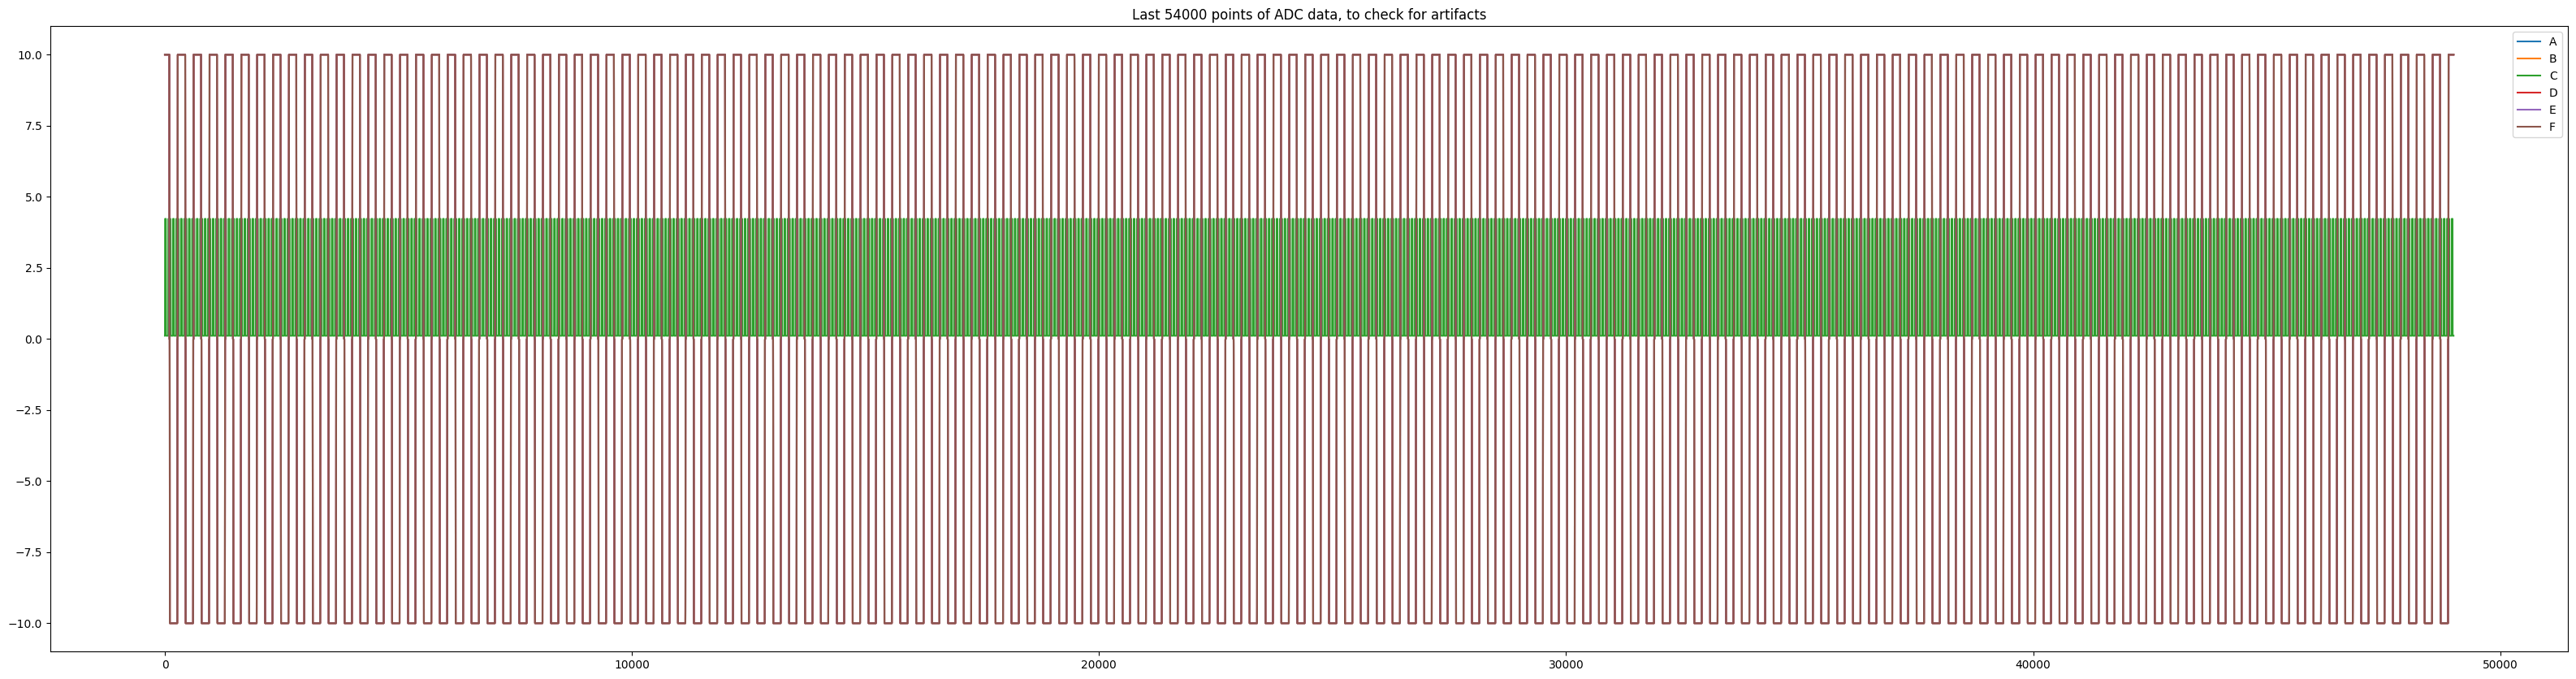

In [9]:


# plot the data for all ADCS from 100000 to 100500
plt.figure(figsize=(40,10))

adc_data = {}
# crop all adc channel data to the shortest one, and throw out the last 4000 points


for adc in ADCS:
    adc_data[adc] = adc_data_raw[adc][:min_length-55000]
    plt.plot(adc_data[adc][min_length-104000:])

plt.legend(ADCS)
plt.title('Last 54000 points of ADC data, to check for artifacts')
plt.show()


del adc_data_raw


In [10]:


# Assuming trigger_data is an array of trigger signal values
trigger_data = np.array(adc_data['C'])  # Use ADC C as trigger data

DATA_ADCS = ['A', 'B', 'D', 'E', 'F']  # ADCs that contain data

# Define thresholds
low_state_threshold = 1.0  # Threshold for low state
high_state_min_duration = 22  # Minimum duration for a high state to be considered 'long'

# Identify indices where trigger is in low state
low_state_indices = np.where(trigger_data < low_state_threshold)[0]

# Identify long high state periods
high_state_indices = np.where(trigger_data >= low_state_threshold)[0]
high_state_windows = np.split(high_state_indices, np.where(np.diff(high_state_indices) != 1)[0] + 1)
long_high_state_indices = [window for window in high_state_windows if len(window) >= high_state_min_duration]

# Process each ADC data
adc_averages = {adc: [] for adc in DATA_ADCS}

# Find valid low state windows considering long high states
valid_low_state_windows = []
for i in range(len(long_high_state_indices) - 1):
    start = long_high_state_indices[i][-1] + 1
    end = long_high_state_indices[i + 1][0]
    valid_low_state_window = np.arange(start, end)
    valid_low_state_windows.append(valid_low_state_window)


# Process valid low state windows
for window in valid_low_state_windows:
    if len(window) == 0:
        continue
    for adc in DATA_ADCS:
        adc_average = np.mean(adc_data[adc][window])
        adc_averages[adc].append(adc_average)


# Plot the averages

# del adc_data

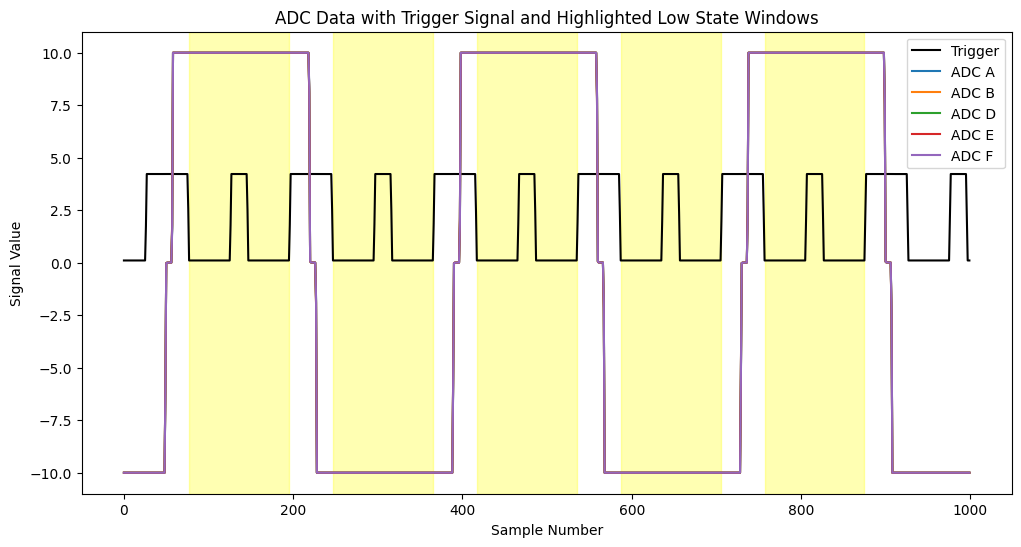

In [11]:

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the trigger data
plt.plot(trigger_data[:1000], label='Trigger', color='black')

# Highlight valid low state windows
for window in valid_low_state_windows:
    if len(window) > 0 and window[-1] < 1000:
        plt.axvspan(window[0], window[-1], color='yellow', alpha=0.3)

# Plot a sample of the ADC data
for adc in DATA_ADCS:
    plt.plot(adc_data[adc][:1000], label=f'ADC {adc}')
    ...

plt.legend()
plt.title("ADC Data with Trigger Signal and Highlighted Low State Windows")
plt.xlabel("Sample Number")
plt.ylabel("Signal Value")
plt.show()

del adc_data

156938
156938
156938
156938
156938
156938


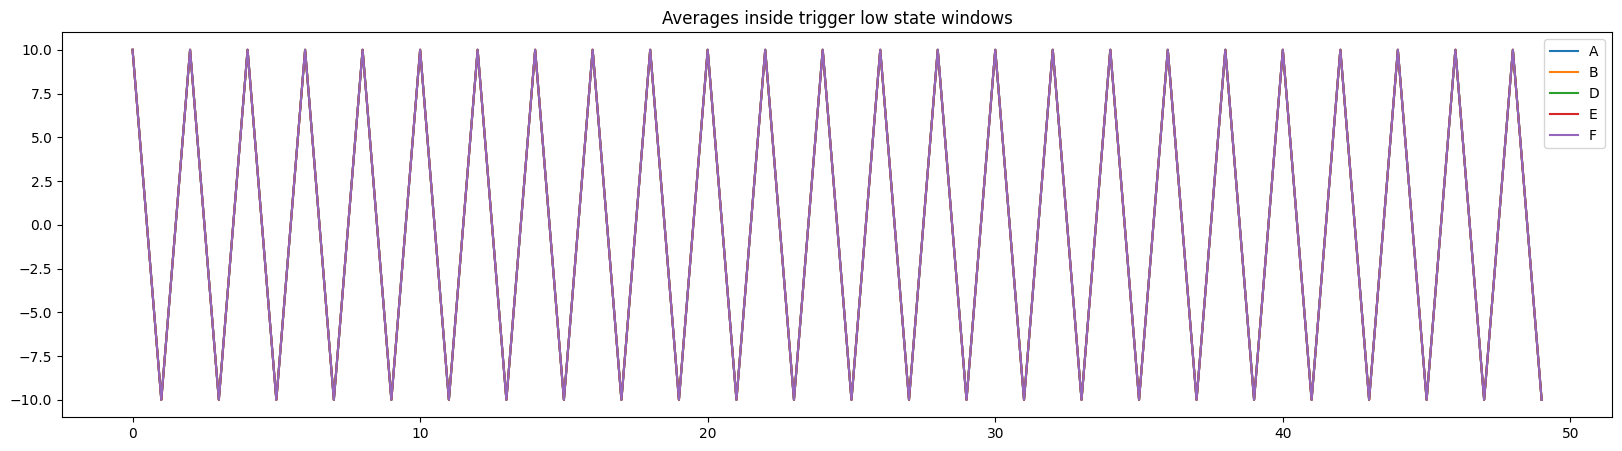

In [12]:
print(len(adc_averages['A']))

plt.figure(figsize=(20, 5))
# Plot the results
for adc in DATA_ADCS:
    plt.plot(adc_averages[adc][-50:])
    print(len(adc_averages[adc]))

plt.legend(DATA_ADCS)
plt.title("Averages inside trigger low state windows")
plt.show()



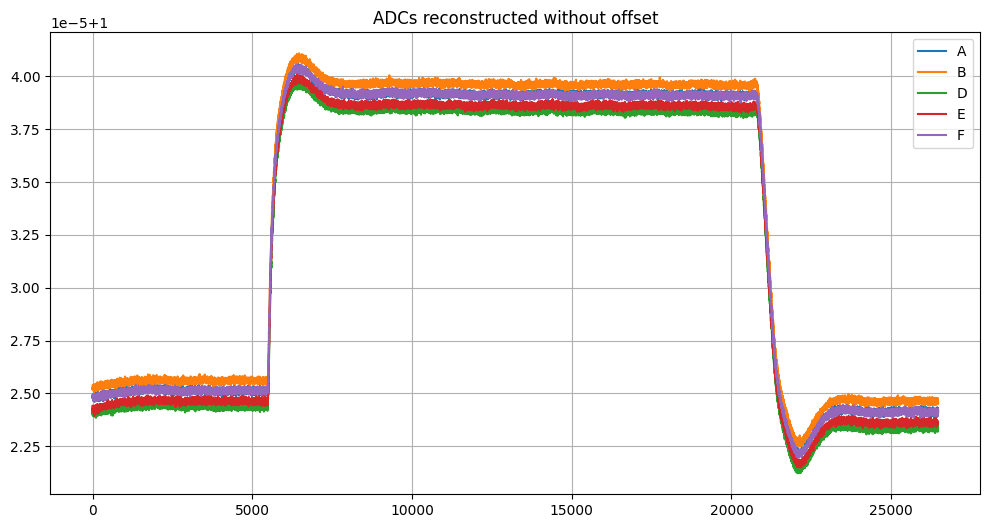

In [13]:
plt.figure(figsize=(12, 6))

v_meas_nooffset = {adc: [] for adc in DATA_ADCS}

for adc in DATA_ADCS:
    v_meas_nooffset[adc] = [(-adc_averages[adc][i] + adc_averages[adc][i+1])/2 for i in range(1, len(adc_averages[adc])-1, 2)]
    
TRIM = 2000


adc_no_offset = {adc: [] for adc in DATA_ADCS}  
# remove outliers
for adc in DATA_ADCS:
    adc_no_offset[adc] = np.array(v_meas_nooffset[adc])[50000:-TRIM]

for adc in DATA_ADCS:
    plt.plot(remove_outliers(adc_no_offset[adc]))

plt.title("ADCs reconstructed without offset")
plt.legend(DATA_ADCS)
plt.grid()
plt.show()

2.803211017879704


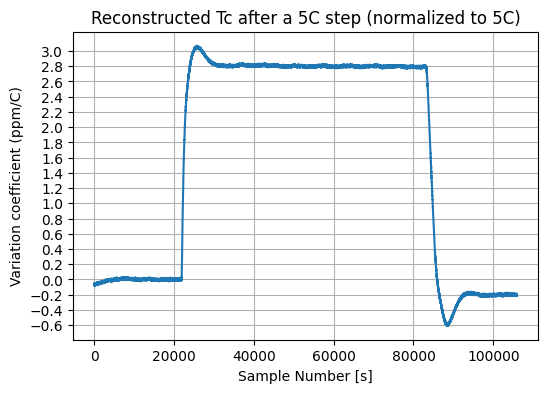

In [18]:
plt.figure(figsize=(6, 4))

# calculate the average of the channels in time
averages_calc = []

time_in_seconds = np.arange(0, len(adc_no_offset) * 4, 4)

for i in range(len(adc_no_offset[DATA_ADCS[0]])):
    average = 0
    for adc in DATA_ADCS:
        average += adc_no_offset[adc][i]
    averages_calc.append(average/len(DATA_ADCS))

averages = remove_outliers(np.array(averages_calc))

zero = np.mean(averages[2500:5000])

variations = 1e6*(averages-zero)/5

print(np.mean(variations[7500:20000]))

time_in_seconds = np.arange(0, len(variations) * 4, 4) 

# plot the average of the channels in time
plt.plot(time_in_seconds, variations)

# make more y ticks
plt.yticks(np.arange(-0.6, 3.2, 0.2))

plt.title("Reconstructed Tc after a 5C step (normalized to 5C)")
plt.xlabel("Sample Number [s]")
plt.ylabel("Variation coefficient (ppm/C)")

plt.grid()
plt.savefig('9_final_tc.png', dpi = 300, bbox_inches='tight')
plt.show()